<a href="https://colab.research.google.com/github/ipleiria-robotics/MonoCamCalib4AD/blob/master/Calibration%26BirdsEyeView.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibration

**ATUALIZAR**

In [4]:
!git clone https://github.com/ipleiria-robotics/MonoCamCalib4AD.git

Cloning into 'MonoCamCalib4AD'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 98 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (98/98), done.


Each camera it’s composed by one sensor and one lens, and is characterized by its intrinsic parameters, which depend on sensor and lens, and its extrinsic parameters, which describes the camera pose in the world around. Assuming a single, unchanged, camera throughout the experience, the intrinsic parameters are fixed, so they need to be determined only once. On the other hand, the extrinsic parameters depend on the camera motion with respect to the world reference frame. Having the calibration done, the homography can be used manipulate the virtual camera pose in order to obtaine a desired camera point-of-view.

This notebook is essentially divided in two main section.

*   **Intrinsic parameters and calibration**
  * Normal/Wide Angle Lens
  * Fish Eye Lens
*   Extrinsic Parameters and the Homography
  * Fish Eye Lenss

\

**NOTE:** This is a companion implementation for the following paper, so you should read it before proceeding:
[DOI: 10.1109/ICARSC49921.2020.9096104](https://ieeexplore.ieee.org/document/9096104)

## Normal and Wide Angle Lens

The calibration process is very similar for both normal/wide-angle and fisheye lens. One of the difference is in the calibration flags, more significant in normal calibration. \\
These flags are optional and choosing them depend on the camera + lens setup, i.e., on the type of distortion present. \\
You can change these parameters according to your purpose. 

**Calibration Flags**
*   CV_CALIB_USE_INTRINSIC_GUESS
*   CV_CALIB_FIX_PRINCIPAL_POINT
*   CV_CALIB_FIX_ASPECT_RATIO
*   CV_CALIB_ZERO_TANGENT_DIST
*   CV_CALIB_FIX_K1,...,CV_CALIB_FIX_K6 \
\
*   CV_CALIB_RATIONAL_MODEL
*   CV_CALIB_THIN_PRISM_MODEL
*   CV_CALIB_TILTED_MODEL




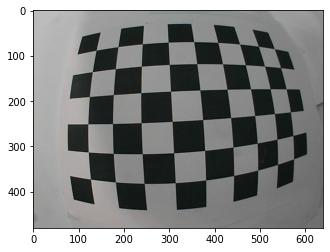

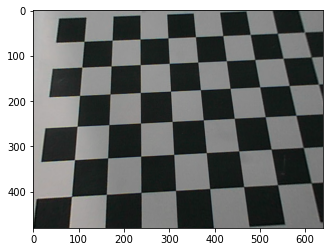

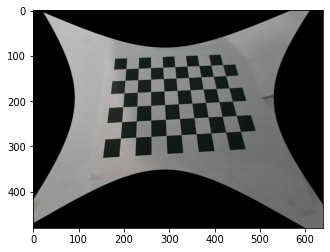

In [19]:
import numpy as np
from cv2 import cv2
import glob
import matplotlib.pyplot as plt

# Chessboard sizes
CHECKERBOARD_SIZE = (9,6)
CHECKERBOARD_SIDE_SIZE = 25.4

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((1, CHECKERBOARD_SIZE[0]*CHECKERBOARD_SIZE[1], 3), np.float32)
objp[0,:,:2] = CHECKERBOARD_SIDE_SIZE * \
np.mgrid[0:CHECKERBOARD_SIZE[0], 0:CHECKERBOARD_SIZE[1]].T.reshape(-1, 2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# All the images must to have the same size for calibration
images = glob.glob('MonoCamCalib4AD/Normal_Images/*.jpg')

for fname in images:

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_SIZE,None)

    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)

        # Draw and display the corners
          #img = cv2.drawChessboardCorners(img, CHECKERBOARD_SIZE, corners2,ret)
          #cv2.imshow('img',img)

# Flags for calibration, use "0" if you dont pretend any particular calibration.
calibration_flags=cv2.CALIB_RATIONAL_MODEL

ret,K,D,rvecs,tvecs,stdDeviationsIntrinsics,stdDeviationsExtrinsics,perViewErrors = \
  cv2.calibrateCameraExtended(
        objpoints,
        imgpoints, 
        gray.shape[::-1],
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        calibration_flags
  )

# Load image for test calibration
img =cv2.imread("MonoCamCalib4AD/Normal_Images/65.jpg")
new_K,roi=cv2.getOptimalNewCameraMatrix(K,D,gray.shape[::-1],1,gray.shape[::-1])

# Undistort
undistorted_img1 = cv2.undistort(img, K, D, None, None)
map1,map2 = cv2.initUndistortRectifyMap(K,D,None,new_K,gray.shape[::-1],5)
undistorted_img2 = cv2.remap(img,map1,map2,cv2.INTER_LINEAR)

plt.imshow(img)
plt.show()
plt.imshow(undistorted_img1)
plt.show()
plt.imshow(undistorted_img2)
plt.show()

## Fisheye Lens

The code is similar to the one used earlier, with slight changes, given that the distortion model used here is specific to the fisheye lens. \\
In *cv2.fisheye.estimateNewCameraMatrixForUndistortRectify* function it is possible to set a FOV scale to crop a region on the image.


**Calibration flags:**


*   CALIB_USE_INTRINSIC_GUESS = 1 << 0
*   CALIB_RECOMPUTE_EXTRINSIC = 1 << 1
*   CALIB_CHECK_COND = 1 << 2
*   CALIB_FIX_SKEW = 1 << 3
*   CALIB_FIX_K1 = 1 << 4
*   CALIB_FIX_K2 = 1 << 5
*   CALIB_FIX_K3 = 1 << 6
*   CALIB_FIX_K4 = 1 << 7
*   CALIB_FIX_INTRINSIC = 1 << 8
*   CALIB_FIX_PRINCIPAL_POINT = 1 << 9

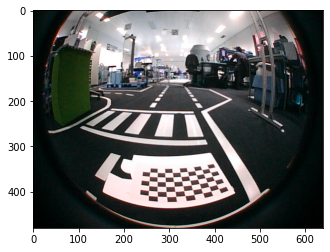

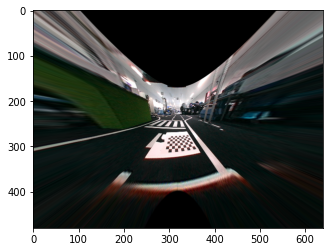

In [20]:
from cv2 import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# Chessboard sizes
CHECKERBOARD_SIZE = (9,6)
CHECKERBOARD_SIDE_SIZE = 25.4

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((1, CHECKERBOARD_SIZE[0]*CHECKERBOARD_SIZE[1], 3), np.float32)
objp[0,:,:2] = CHECKERBOARD_SIDE_SIZE * \
np.mgrid[0:CHECKERBOARD_SIZE[0], 0:CHECKERBOARD_SIZE[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# All the images must to have the same size for calibration
images = glob.glob('MonoCamCalib4AD/Fisheye_Images/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_SIZE, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)

    # Image points (after refinin them)
    if ret == True:

        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1))
        imgpoints.append(corners)
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners,ret)
        #plt.imshow(img)
        #plt.show()

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

# Calibration parameters
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC

ret,K, D, rvecs, tvecs = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        None,
        None,
        None,
        None,
        calibration_flags  
    )

# Load image for test calibration
original = cv2.imread("MonoCamCalib4AD/Example.jpg")

# Calibration Functions
new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, gray.shape[::-1], np.eye(3), balance=1, new_size=gray.shape[::-1],fov_scale=1)
# To recentre the image
new_K[0,2]=int(original.shape[1]/2)
new_K[1,2]=int(original.shape[0]/2)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, gray.shape[::-1], cv2.CV_16SC2)
undistorted_img = cv2.remap(original, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

plt.imshow(original)
plt.show()
plt.imshow(undistorted_img)
plt.show()

Having finished the calibration, it is possible to execute the correction using two methods: the first one, characterized by saving the ***K*** and ***D*** variables, intrisic parameters, and use all the three *calibration funcitons*; the second option is by using the ***map1*** and ***map2*** variables to save time and, this away, one just needs to use the last *calibration function*.

# Homography


After getting the intrinsic parameters, which can be done only once, the next step is to compute the extrinsic parameters, which depends on the camera pose. 
These values have as reference a world reference frame, in this case, the origin of a chessboard on the floor. 
The position of the virtual camera is defined by the *rvec2* and *tvec2* vectors, with the first one being the orientation/rotation in axis-angle format, and the second one the translation, in cartesian coordinates. 

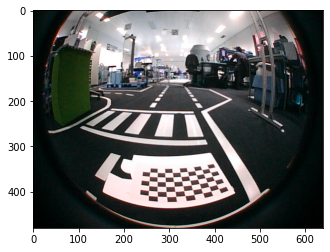

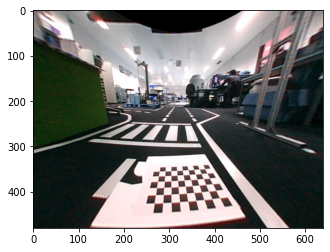

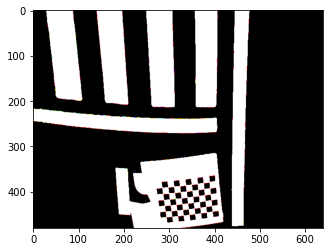

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.linalg import inv

# Load an image
original = cv2.imread('MonoCamCalib4AD/Example.jpg')

# Load intrinsic parameters
K=np.loadtxt('MonoCamCalib4AD/K_file.txt')
D=np.loadtxt('MonoCamCalib4AD/D_file.txt')

# Chessboard sizes
CHECKERBOARD_SIZE = (9,6)
CHECKERBOARD_SIDE_SIZE = 25.4

# Arrays to store object points and image points from all the images.
objpoints = np.empty((0, CHECKERBOARD_SIZE[0] * CHECKERBOARD_SIZE[1], 1, 3), np.float32)
imgpoints = np.empty((0, CHECKERBOARD_SIZE[0] * CHECKERBOARD_SIZE[1], 1, 2), np.float32)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CHECKERBOARD_SIZE[0] * CHECKERBOARD_SIZE[1], 1, 3), np.float32)
objp[:, 0, :2] = CHECKERBOARD_SIDE_SIZE * \
np.mgrid[0:CHECKERBOARD_SIZE[0], 0:CHECKERBOARD_SIZE[1]].T.reshape(-1, 2)

# Calibration Functions
new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, original.shape[-2::-1], np.eye(3), balance=1, new_size=original.shape[-2::-1],fov_scale=0.58)
# To recentre the image
new_K[0,2]=int(original.shape[1]/2)
new_K[1,2]=int(original.shape[0]/2)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, original.shape[-2::-1], cv2.CV_16SC2)
undistorted_img1 = cv2.remap(original, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# Get rotation and translation vector of the original image
ret, corners1 = cv2.findChessboardCorners(undistorted_img1, CHECKERBOARD_SIZE)
retval, rvec1, tvec1 = cv2.solvePnP(objp, corners1, new_K, np.zeros((4, 1), np.float32))

# Desire rotation and translation over the object
rvec2=np.array([[0.0],      # X
                [0.0],      # Y
                [-0.12]])   # Z

tvec2=np.array([[-150.0],   # X
                [-400.0],   # Y
                [-375.0]])  # Z

# Compute homography matrix from original image to desire position
R1,jacob1 = cv2.Rodrigues(rvec1)
R2,jacob2=cv2.Rodrigues(rvec2)
R1toR2 = R2 @ R1.transpose()
T1toT2 = R2 @ (-R1.transpose() @ tvec1) + tvec2
normal = np.array([[0.0],
                   [0.0],
                   [1.0]])
normal1 = R1 @ normal
origin = np.zeros((3,1),np.float64)
origin1 = R1 @ origin + tvec1
d_inv =  1.0 / (normal1.transpose() @ origin1)
homography_euclidean = R1toR2 + d_inv * T1toT2 @ normal1.transpose()
homography2 = new_K @ homography_euclidean @ inv(new_K)
homography2 = homography2/homography2[2][2]
homography_euclidean = homography_euclidean/homography_euclidean[2][2]

# Apply warp prespective to image
img1_warp = cv2.warpPerspective(undistorted_img1, homography2, original.shape[-2::-1])
cv2.threshold(img1_warp,150,255,cv2.THRESH_BINARY,img1_warp)

plt.imshow(original)
plt.show()
plt.imshow(undistorted_img1)
plt.show()
plt.imshow(img1_warp)
plt.show()